In [ ]:
import sys
import os

# Add project root (cinnomon-cnn) to Python path
sys.path.append(os.path.abspath('..'))  # adjust if notebook is inside training folder


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from training.preprocess import *
from training.model import *
from backend.src.utils import *
from training.train import train_losses, val_losses, train_accuracies, val_accuracies
from pathlib import Path


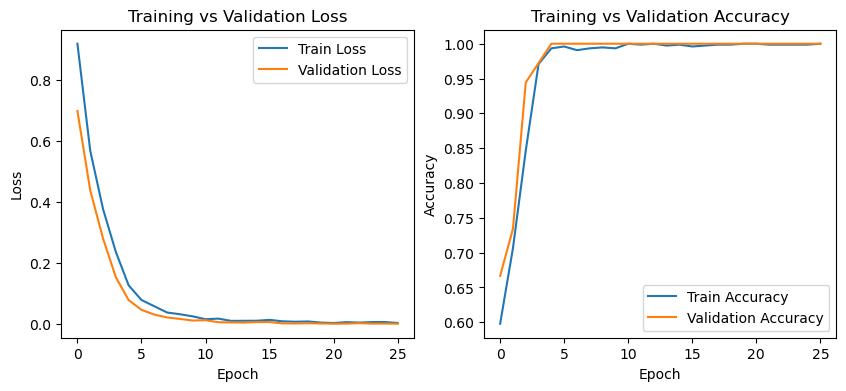

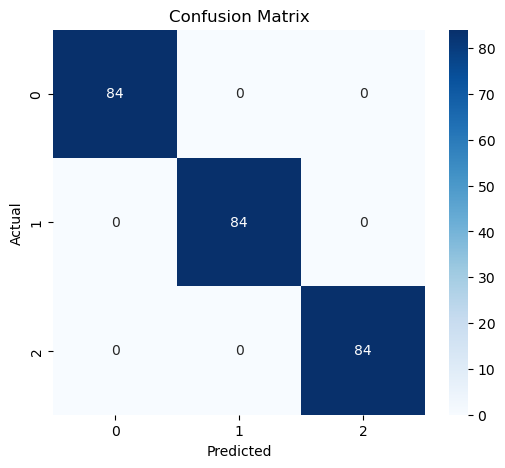

Classification Report:

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        84
         Low       1.00      1.00      1.00        84
      Medium       1.00      1.00      1.00        84

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252

Overlap between train and test (data leakage check): False


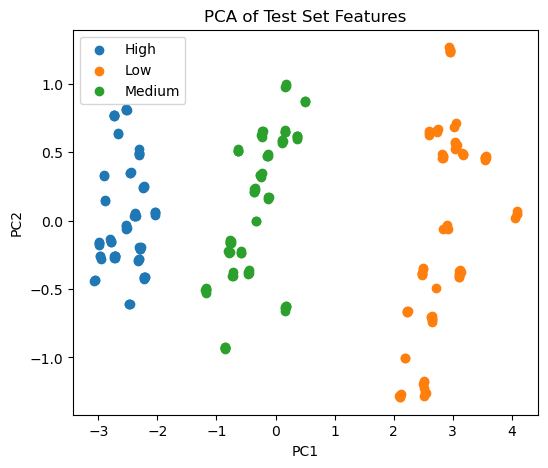

ANN(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [15]:
# Get project root (assuming notebook is inside 'training' folder)
project_root = Path.cwd().parent  # one level up from 'training' if notebook is inside it
model_dir = project_root / 'backend' / 'models'

# Ensure the folder exists
os.makedirs(model_dir, exist_ok=True)

# Set the model path
model_path = model_dir / "best_model.pth"

model = ANN()  # Same as used during training

# Load best model
model.load_state_dict(torch.load(model_path))

# --- 5. Plot Loss & Accuracy curves ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# --- 6. Test Evaluation ---
y_test_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_test_pred.extend(predicted.tolist())

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# Data leakage check
train_rows = X_train_tensor.numpy()
test_rows = X_test_tensor.numpy()
overlap = np.any(np.all(np.isin(test_rows[:, None], train_rows), axis=2))
print("Overlap between train and test (data leakage check):", overlap)

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)
plt.figure(figsize=(6,5))
for label in np.unique(y_test_enc):
    plt.scatter(X_pca[y_test_enc==label,0], X_pca[y_test_enc==label,1], label=le.classes_[label])
plt.legend()
plt.title("PCA of Test Set Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# Load the best saved weights
model.load_state_dict(torch.load(model_path))

# Set to evaluation mode
model.eval()
